In [1]:
import sys
sys.path.append("../")
import pandas as pd
import numpy as np
from ADKit.AutoDiff import Ad_Var
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
battles = pd.read_csv("battles.csv")

In [3]:
battles

,name,attacker_outcome,attacker_size,defender_size
0,Battle of the Golden Tooth,win,15000,4000
1,Battle of Riverrun,win,15000,10000
2,Battle of the Green Fork,loss,18000,20000
3,Battle of the Whispering Wood,win,1875,6000
4,Battle of the Camps,win,6000,12625
5,Battle of Torrhen's Square,win,244,900
6,Sack of Winterfell,win,618,2000
7,Battle of Oxcross,win,6000,10000
8,Siege of Storm's End,win,5000,20000
9,Battle of the Fords,loss,20000,10000


In [4]:
battles['attacker_outcome'] = battles['attacker_outcome'].eq('win').mul(1) # transform the string outcome to 0/1s

In [5]:
scaler = MinMaxScaler()
battles_scaled = battles.copy()
# scale the independent vars
battles_scaled[['attacker_size','defender_size']] = pd.DataFrame(scaler.fit_transform(battles[['attacker_size','defender_size']]))

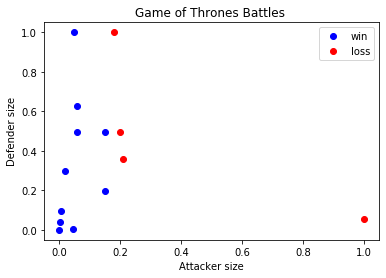

In [6]:
plt.plot(battles_scaled.loc[battles['attacker_outcome'] == 1,'attacker_size'], battles_scaled.loc[battles['attacker_outcome'] == 1,'defender_size'],'bo', label = "win")
plt.plot(battles_scaled.loc[battles['attacker_outcome'] == 0,'attacker_size'], battles_scaled.loc[battles['attacker_outcome'] == 0,'defender_size'],'ro', label = "loss")
plt.xlabel('Attacker size')
plt.ylabel('Defender size')
plt.title('Game of Thrones Battles ')
plt.legend()
plt.show()

In [7]:
# Initiate three Ad_Var for the weight of Attacker_size, weight of Defender_size, and the intercept
attack_coef = Ad_Var(0, np.array([1,0,0]))
defend_coef = Ad_Var(0, np.array([0,1,0]))
intercept = Ad_Var(0, np.array([0,0,1]))

N = 500
lam = 0.5

for j in range(N):
    for i in range(len(battles_scaled['attacker_size'])):
        # z = attack_coef*attacker_size + defend_coef*defender_size + intercept
        # f = 1/(1 + exp(-z))
        # L = 1/2*(f - y)**2
        z = battles_scaled.loc[i,'attacker_size']*attack_coef + battles_scaled.loc[i,'defender_size']*defend_coef + intercept
        f = Ad_Var.logistic(z)
        L = (f - battles_scaled.loc[i,'attacker_outcome'])**2/2
        attack_coef.set_val(attack_coef.get_val() - lam*L.get_ders()[0])
        defend_coef.set_val(defend_coef.get_val() - lam*L.get_ders()[1])
        intercept.set_val(intercept.get_val() - lam*L.get_ders()[2])

In [8]:
print('Attacker size coef: ',attack_coef.get_val())
print('Defender size coef: ', defend_coef.get_val())
print('Intercept: ', intercept.get_val())

Attacker size coef:  -12.27774911375575
Defender size coef:  -1.7737313645262605
Intercept:  3.061811566871836


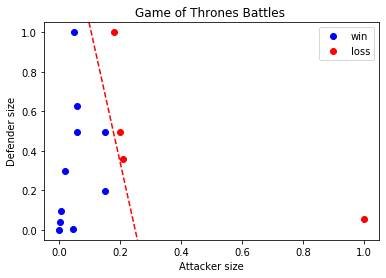

In [9]:
plt.plot(battles_scaled.loc[battles_scaled['attacker_outcome'] == 1,'attacker_size'], battles_scaled.loc[battles_scaled['attacker_outcome'] == 1,'defender_size'],'bo', label = "win")
plt.plot(battles_scaled.loc[battles_scaled['attacker_outcome'] == 0,'attacker_size'], battles_scaled.loc[battles_scaled['attacker_outcome'] == 0,'defender_size'],'ro', label = "loss")

plt.xlabel('Attacker size')
plt.ylabel('Defender size')
plt.title('Game of Thrones Battles ')
plt.legend()
ax = plt.gca()
ax.autoscale(False)
x_vals = np.array(ax.get_xlim())
y_vals = -(x_vals * attack_coef.get_val() + intercept.get_val())/defend_coef.get_val()
plt.plot(x_vals, y_vals, '--', c="red")
plt.show()

In [10]:
# my unsucessful try on generalized gradient descent, below is a gradient descent only works for logistic regression

X_train = battles_scaled[['attacker_size','defender_size']]
y_train = battles_scaled['attacker_outcome']
N = 500
lam = 0.5

def log_gradient_descent(X_train, y_train, N, lam, var = 2, intercept = True):
    var_list = []
    if intercept == True:
        var = var + 1
        X_train['intercept'] = 1
    for i in range(var):
        seed = np.zeros(var)
        seed[i] = 1
        var_list.append(Ad_Var(0,seed))
    for j in range(N):
        for row in range(len(y_train)):
            z = 0 # initiate z to be 0 for updates
            for var_k in range(var):
                z = z + X_train.iloc[row,var_k]*var_list[var_k] 
            f = Ad_Var.logistic(z)
            L = (f - y_train[row])**2/2
            for var_k in range(var):
                var_list[var_k].set_val(var_list[var_k].get_val() - lam*L.get_ders()[var_k])
    return var_list

In [11]:
results = log_gradient_descent(X_train,y_train,N,lam)

/Users/ivywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [12]:
print('Attacker size coef: ',results[0].get_val())
print('Defender size coef: ', results[1].get_val())
print('Intercept: ', results[2].get_val())

Attacker size coef:  -12.27774911375575
Defender size coef:  -1.7737313645262605
Intercept:  3.061811566871836


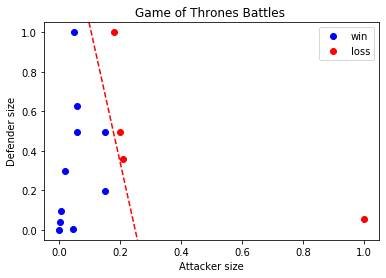

In [13]:
plt.plot(battles_scaled.loc[battles_scaled['attacker_outcome'] == 1,'attacker_size'], battles_scaled.loc[battles_scaled['attacker_outcome'] == 1,'defender_size'],'bo', label = "win")
plt.plot(battles_scaled.loc[battles_scaled['attacker_outcome'] == 0,'attacker_size'], battles_scaled.loc[battles_scaled['attacker_outcome'] == 0,'defender_size'],'ro', label = "loss")

plt.xlabel('Attacker size')
plt.ylabel('Defender size')
plt.title('Game of Thrones Battles ')
plt.legend()
ax = plt.gca()
ax.autoscale(False)
x_vals = np.array(ax.get_xlim())
y_vals = -(x_vals * results[0].get_val() + results[2].get_val())/results[1].get_val()
plt.plot(x_vals, y_vals, '--', c="red")
plt.show()

In [14]:
def gd(f, df, x_list , lam , num_steps):
    for j in range(num_steps):
        for x in range(len(x_list)):
            x.set_val(x.get_val() - lam*df(x))
        fun = f(xx)
    return(x,fun)